In [1]:
import numpy as np
import pandas as pd
import seaborn as sb

In [2]:
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')

# EDA

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Preprocessing

In [5]:
X = train_data.drop('Survived', axis=1)
y = train_data.Survived

## Cleaning

In [6]:
X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X_test = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

X.dropna(subset=['Embarked'], inplace=True)
y.drop(y.index.difference(X.index), inplace=True)

X.Age.fillna(0.0, inplace=True)
X_test.fillna(0.0, inplace=True)

## Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

sex_le = LabelEncoder()
X.Sex = sex_le.fit_transform(X.Sex)
X_test.Sex = sex_le.transform(X_test.Sex)

embarked_le = LabelEncoder()
X.Embarked = embarked_le.fit_transform(X.Embarked)
X_test.Embarked = embarked_le.transform(X_test.Embarked)

# Modeling

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_cls = DecisionTreeClassifier(random_state=42)
grid_search_params = {
    'max_depth': [10, 15, 20, 25, 30, 50, 100],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}
model = GridSearchCV(estimator=tree_cls, param_grid=grid_search_params)
model.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, 30, 50, 100],
                         'splitter': ['best', 'random']})

In [9]:
print("Best depth :", model.best_estimator_.get_depth())
print("Best number of leaves :", model.best_estimator_.get_n_leaves())
print("Best params :", model.best_estimator_.get_params())

Best depth : 10
Best number of leaves : 146
Best params : {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 42, 'splitter': 'random'}


# Evaluation

In [10]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X)
print("Accuracy on train set :", accuracy_score(y, y_pred))
print("F1 score on train set :", f1_score(y, y_pred))

Accuracy on train set : 0.8953880764904387
F1 score on train set : 0.8452579034941763


# Explainability : feature importance

<AxesSubplot:xlabel='value', ylabel='feature'>

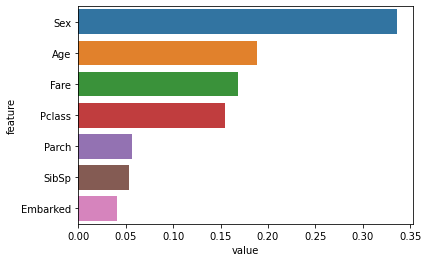

In [11]:
feature_importance_df = pd.DataFrame({'feature': X.columns, 'value': model.best_estimator_.feature_importances_})
feature_importance_df.sort_values(by='value', ascending=False, inplace=True)

sb.barplot(data=feature_importance_df, x='value', y='feature')

# Kaggle submission

Now we test our model against the test set from Kaggle

In [12]:
# predictions
y_test = model.predict(X_test)

# output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_test})
output.to_csv('submission.csv', index=False)